# Capstone Project Report

## Table of contents
* [Part 1: Business Problem](#introduction)
* [Part 2: Data Understanding](#data)
* [Part 3: Methodology](#methodology)
* [Part 4: Analysis](#analysis)
* [Part 5: Results](#results)
* [Part 6: Discussion](#discussion)
* [Part 7: Conclusion](#conclusion)

## Part 1: Business Problem <a name="introduction"></a>

A businessman wants to open a new Asian restaurant in New York city so he needs an advice for the location. He doesn't want to be in a high competitive location with other restaurants nearby because he just has enough capital to open a small restaurant. By the way, he requires 2 main points: 

1. No other Asian restaurant within the same neighbourhood. 
2. The restaurant's density is not too crowded (it means there are 5 restaurants maximum within a neighbourhood).

My job as a data scientist will help him to pick the best location that is suitable for his needs.

## Part 2: Data Understanding <a name="data"></a>

I will use Foursquare data to understand more about restaurant market in New York city, some data I need is:

1. location: to pick where a venue is (lat,long)
2. categories: category of the venue (coffeeshop, restaurant, Asian restaurant, etc.)

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

In [ ]:
# Get dataset of New York
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

In [ ]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [ ]:
neighborhoods_data = newyork_data['features']

In [ ]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [ ]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [265]:
# Check the data frame
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.89470517661,-73.84720052054902
1,Bronx,Co-op City,40.87429419303012,-73.82993910812398
2,Bronx,Eastchester,40.887555677350775,-73.82780644716412
3,Bronx,Fieldston,40.89543742690383,-73.90564259591682
4,Bronx,Riverdale,40.890834493891305,-73.9125854610857


<b>Foursquare API connect</b>

In [266]:
CLIENT_ID = '2BEDWJ3DPTS5FYNZNMKDK00ASCPWRE5WIGW4GNKJ2YIDJ1LG' # your Foursquare ID
CLIENT_SECRET = 'CE0EEKHXO2XOEIAKAFC0C1VNVEXGXBLWLQUHF3UTWKGN2DQL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2BEDWJ3DPTS5FYNZNMKDK00ASCPWRE5WIGW4GNKJ2YIDJ1LG
CLIENT_SECRET:CE0EEKHXO2XOEIAKAFC0C1VNVEXGXBLWLQUHF3UTWKGN2DQL


In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],latitudes=neighborhoods['Latitude'],longitudes=neighborhoods['Longitude'])

In [267]:
# Check the size of newyork_venues
print(newyork_venues.shape)
newyork_venues.head()

(10273, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.89470517661,-73.84720052054902,Lollipops Gelato,40.894123150205274,-73.84589162362325,Dessert Shop
1,Wakefield,40.89470517661,-73.84720052054902,Rite Aid,40.896649,-73.8448461,Pharmacy
2,Wakefield,40.89470517661,-73.84720052054902,Carvel Ice Cream,40.890486685759605,-73.84856772568665,Ice Cream Shop
3,Wakefield,40.89470517661,-73.84720052054902,Walgreens,40.896687,-73.84485,Pharmacy
4,Wakefield,40.89470517661,-73.84720052054902,Dunkin',40.8904587811365,-73.84908886747644,Donut Shop


In [268]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 432 uniques categories.


In [ ]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

In [269]:
newyork_onehot.shape

(10273, 432)

In [ ]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped

In [270]:
newyork_grouped.shape

(300, 432)

In [271]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [272]:
# Display top 10 venues for each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Supermarket,Deli / Bodega,Fried Chicken Joint,Fast Food Restaurant,Bakery,Gas Station,Pharmacy,Check Cashing Service,Donut Shop
1,Annadale,American Restaurant,Diner,Liquor Store,Dance Studio,Sports Bar,Train Station,Park,Pizza Place,Bakery,Pharmacy
2,Arden Heights,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Women's Store,Fast Food Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
3,Arlington,Bus Stop,Deli / Bodega,Grocery Store,Boat or Ferry,Women's Store,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant
4,Arrochar,Deli / Bodega,Italian Restaurant,Bagel Shop,Bus Stop,Food Truck,Taco Place,Sandwich Place,Supermarket,Mediterranean Restaurant,Athletics & Sports


In [273]:
neighborhoods_venues_sorted.shape

(300, 11)

## Part 3: Methodology <a name="methodology"></a>

The methodology I will do:

- I will find the neighbourhood that has Asian restaurants in New York city to drop it.
- I will calculate the total restaurant in each neighbourhood then remove which one has more than 5 restaurants.

Finally, I will have the short list of suggested locations for him to call to check the leasing price to make the decision of which neighbourhood he should open a Asian restaurant.

### Cluster Neighborhoods

In [ ]:
# set number of clusters
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = neighborhoods

newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [ ]:
# Drop nan rows 
newyork_merged.dropna(subset = ['Cluster Labels'], inplace=True)

In [ ]:
newyork_merged.shape

In [ ]:
newyork_merged['Cluster Labels'] = newyork_merged['Cluster Labels'].astype(int)
newyork_merged.head()

In [274]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Part 4: Analysis <a name="analysis"></a>

In [275]:
# Asian Restaurants list
newyork_asian_res = newyork_venues[newyork_venues['Venue Category'] == 'Asian Restaurant']
print('There are', newyork_asian_res.shape[0],'Asian Restaurants in New York city.')
newyork_asian_res.head()

There are 54 Asian Restaurants in New York city.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
637,Throgs Neck,40.81510925804005,-73.81635002158441,Green Dragon,40.81887820776003,-73.81679306899113,Asian Restaurant
653,Parkchester,40.837937822267286,-73.85600310535783,Neerob,40.83611083931938,-73.85490233193293,Asian Restaurant
676,Parkchester,40.837937822267286,-73.85600310535783,Sing Hing,40.839496652600666,-73.85841341148014,Asian Restaurant
698,Westchester Square,40.8406194964327,-73.84219407604444,Kai Asian Fusion,40.843590837833744,-73.84558937077266,Asian Restaurant
894,Pelham Bay,40.85064140940335,-73.8320737824047,Shangri-La,40.84715972410305,-73.83264181934335,Asian Restaurant


In [276]:
# Asian Restaurants neighbourhood list
neighborhood_asian = newyork_asian_res['Neighborhood'].value_counts().rename_axis('Neighborhood').reset_index(name='Counts')
print(neighborhood_asian.shape)
neighborhood_asian.head()

(40, 2)


,Neighborhood,Counts
0,College Point,3
1,Brooklyn Heights,2
2,Tudor City,2
3,Parkchester,2
4,Sunnyside Gardens,2


In [ ]:
# Total neighborhoods in New York city
neighborhoods.shape

In [277]:
# create map of Asian Restaurants in New York
latitude = 40.7127281
longitude = -74.0060152
map_asian_res = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, venue, neighborhood in zip(newyork_asian_res['Venue Latitude'], newyork_asian_res['Venue Longitude'], newyork_asian_res['Venue'], newyork_asian_res['Neighborhood']):
    label = '{}, {}'.format(neighborhood, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_asian_res)  
    
map_asian_res

### Find and remove all the neighborhood have more than 5 restaurants

In [ ]:
# Display neighborhood has restaurant
newyork_restaurant = newyork_venues[newyork_venues['Venue Category'].str.contains('Restaurant')]
print(newyork_restaurant.shape)
newyork_restaurant.head()

In [279]:
# Group the neighboorhood to count the total restaurant in each neighborhood and sorting it
neigh_restaurant_count = newyork_restaurant['Neighborhood'].value_counts().rename_axis('Neighborhood').reset_index(name='Counts')
neigh_restaurant_count.sort_values(by=['Counts'],ascending=False, inplace=True)
print(neigh_restaurant_count.shape)
neigh_restaurant_count.head()

(261, 2)


,Neighborhood,Counts
0,Murray Hill,63
1,Greenwich Village,45
2,Chinatown,42
3,Turtle Bay,41
4,Clinton Hill,39


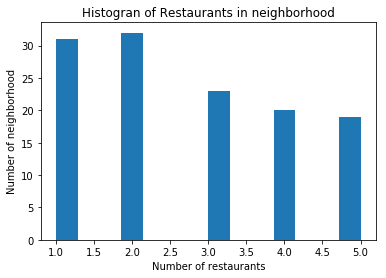

In [278]:
# Draw a histogram chart to see the visual of restaurant frequency
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

neigh_restaurant_count['Counts'].plot(kind = 'hist',bins= 14) 
plt.title('Histogran of Restaurants in neighborhood')
plt.ylabel('Number of neighborhood')
plt.xlabel('Number of restaurants')

plt.show()

In [280]:
# Get a shortlist of neighbours has maximum 5 restaurants
neigh_restaurant_count.drop(neigh_restaurant_count[neigh_restaurant_count['Counts'] > 5].index, inplace = True)

In [237]:
print(neigh_restaurant_count.shape)
neigh_restaurant_count.head() # We got the list of 132 neighborhood

(132, 2)


,Neighborhood,Counts
147,Glen Oaks,5
139,Far Rockaway,5
146,Remsen Village,5
145,Cambria Heights,5
144,Arrochar,5


In [ ]:
neighborhood_asian.drop('Counts', axis=1, inplace=True)

In [238]:
print(neighborhood_asian.shape)
neighborhood_asian.head()

(40, 2)


,Neighborhood,Check
0,College Point,1
1,Brooklyn Heights,1
2,Tudor City,1
3,Parkchester,1
4,Sunnyside Gardens,1


### Merge 2 dataframe based of restaurant counts max 5 to check if there is a neighborhood has Asian restaurant

In [244]:
check_result = pd.merge(neigh_restaurant_count, neighborhood_asian, how='inner', on=['Neighborhood'])
print('There are',check_result.shape[0],'neighborhoods has Asian restaurant')
check_result

There are 7 neighborhoods has Asian restaurant


,Neighborhood,Counts,Check
0,New Lots,4,1
1,Mount Hope,3,1
2,Throgs Neck,3,1
3,Canarsie,3,1
4,Hollis,3,1
5,Edgemere,2,1
6,Paerdegat Basin,1,1


### Finally, we remove 7 neighborhoods to have the final sort list

In [257]:
# Remove 7 neighborhoods in the table above
for i in range(0,7):
    neigh_restaurant_count.drop(neigh_restaurant_count[neigh_restaurant_count['Neighborhood'] == check_result['Neighborhood'][i]].index, inplace=True)

In [258]:
final_result = neigh_restaurant_count
print(final_result.shape)
final_result.head()

(125, 2)


,Neighborhood,Counts
147,Glen Oaks,5
139,Far Rockaway,5
146,Remsen Village,5
145,Cambria Heights,5
144,Arrochar,5


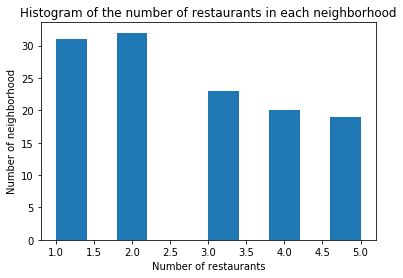

In [264]:
# Draw a histogram chart
final_result['Counts'].plot(kind = 'hist') 

plt.title('Histogram of the number of restaurants in each neighborhood')
plt.ylabel('Number of neighborhood')
plt.xlabel('Number of restaurants')

plt.show()

## Part 5: Results <a name="results"></a>

The result is we has shortlisted from 300 neighborhoods in New York city to 125 neighbourhoods that satisfy at least 2 conditions:

1. No Asian restaurant.
2. No more than 5 restaurants nearby.

If we see the histogram chart, he can make a better decision by choosing places has only 1 restaraunt (about 30 neighborhood location) or 2 restaurants (another 30 locations).

I have tried my best to make data useful for the business requirement.

## Part 6: Discussion <a name="discussion"></a>

I have learned a lot from this course, especially by doing the last project with real dataset for a real world problem / demand. I think I can do better in the future with some ideas. I want to do more for the last project but my skills are not good enough to do it such as:

1. Convert lat, long to x, y to calculate the distant to make better decision.
2. Using Foursquare dataset to check the pricing tier or the popular of the venue.
3. Find the pattern based on the popular Asian restaurant to find another location (neighborhood) that will likely be successful.

## Part 7: Conclusion <a name="conclusion"></a>

I hope that my result will be helpful to solve a part of the business problem. 

It helps the client to save 90% of his time instead of he needs to check all the neighborhood location to find the place. I hope he will enjoy the result of shortlist that he gets from me.

Thank you!